# What Genre Am I?

The purpose of this project is to use machine learning and natural language procressing to determine the genre of a song based on it's lyrics and audio features.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from tqdm import tqdm_notebook
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Collecting + Cleaning Data

I collected my data from 2 main sources: 
- The 380,000+ Lyrics from Metrolyrics kaggle dataset that was created by Gyanendra Mishra (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics)
- Spotify API for audio features such as mode, acousticness & danceability, please refer to spotify's developer documentation for a full list of features and their descriptions: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

### Kaggle Lyrics Data Initial Cleaning

In [2]:
# reading in kaggle data
df = pd.read_csv('/Users/sarinaamin/Downloads/lyrics.csv')
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [3]:
df.drop('index', axis=1, inplace=True)
df.shape # (362237, 5) - Dropped nan values before saving to csv
df.dropna(inplace=True)
df.shape # (266556, 5)

(266556, 5)

In [4]:
# Checking distribution of song genres
df.genre.value_counts()

Rock             109235
Pop               40466
Hip-Hop           24850
Not Available     23941
Metal             23759
Country           14387
Jazz               7970
Electronic         7966
Other              5189
R&B                3401
Indie              3149
Folk               2243
Name: genre, dtype: int64

In [5]:
# 45% of songs were in the rock category
df.genre.value_counts(normalize=True)

Rock             0.409801
Pop              0.151811
Hip-Hop          0.093226
Not Available    0.089816
Metal            0.089133
Country          0.053974
Jazz             0.029900
Electronic       0.029885
Other            0.019467
R&B              0.012759
Indie            0.011814
Folk             0.008415
Name: genre, dtype: float64

In [6]:
# removing all rows with genre 'not available', most seemed to be foreign language songs
# removing genres that made up under 0.02% of dataset each
# decided to focus on smaller selection of genres

df = df[df.genre != 'Not Available'].copy()
df = df[df.genre != 'Other'].copy()
df = df[df.genre != 'Folk'].copy()
df = df[df.genre != 'R&B'].copy()
df = df[df.genre != 'Indie'].copy()

df.shape # (228634, 5)


(228633, 5)

In [7]:
# Genre distribution after removing 5 other genre categories
df.genre.value_counts(normalize=True)

Rock          0.477774
Pop           0.176991
Hip-Hop       0.108689
Metal         0.103918
Country       0.062926
Jazz          0.034859
Electronic    0.034842
Name: genre, dtype: float64

In [8]:
# cleaning song title, lyrics and artist name

df.song = df.song.str.replace('-',' ')
df.song = df.song.str.replace('[^\w\s]','')

df.artist = df.artist.str.replace('-',' ')
df.artist = df.artist.str.replace('[^\w\s]','')

df.lyrics = df.lyrics.str.replace("\n"," ")
df.lyrics = df.lyrics.replace('[^\w\s]','')
df.lyrics = df.lyrics.str.replace('\[','')
df.lyrics = df.lyrics.str.replace('\]','')
df.lyrics = df.lyrics.str.replace(':','')
df.lyrics = df.lyrics.str.replace('Verse','')
df.lyrics = df.lyrics.str.replace('Chorus','')
df.lyrics = df.lyrics.str.replace('?','')
df.lyrics = df.lyrics.str.replace(',','')
df.lyrics = df.lyrics.str.replace("'","")
df.lyrics = df.lyrics.str.replace('\d', '')

In [9]:
# checking distribution year, found some errors in some cells
df.year.value_counts()

2006    65312
2007    58815
2008    15524
2014    10108
2009     8575
2010     8516
2012     8513
2011     8287
2016     7973
2013     7897
2015     7266
2005     4304
2004     2567
2003     1598
2002     1425
2001     1105
2000     1073
1990     1022
1999      913
1997      735
1998      729
1996      684
1995      639
1994      546
1993      487
1992      481
1991      247
1989      241
1977      231
1982      227
1973      224
1980      187
1988      175
1981      168
1984      167
1978      165
1986      164
1979      162
1971      161
1972      148
1974      148
1970      141
1983      138
1985      130
1975      125
1987      114
1976       69
112         4
702         1
67          1
1968        1
Name: year, dtype: int64

In [11]:
# checking rows where year was incorrect

df[df.year == 67]
df[df.year == 112]
df[df.year == 702]

,song,year,artist,genre,lyrics
27657,star,702,clipse,Hip-Hop,Youre my star Its such a wonder how you shine ...


In [12]:
# cleaning incorrect years, artist name was confused for year


df.at[69708, 'artist'] = '112'
df.at[147914, 'artist'] = '112'
df.at[238541, 'artist'] = '112'
df.at[27657, 'artist'] = '702'
df.at[155200, 'artist'] = '0510 ent'

df.at[315540, 'year'] = 2016
df.at[69708, 'year'] = 1999
df.at[147914, 'year'] = 2000
df.at[238541, 'year'] = 1996
df.at[335205, 'year'] = 2001
df.at[27657, 'year'] = 2003


In [14]:
# save to csv
df.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-cleaned-160120.csv', index=False)



In [15]:
df = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-cleaned-160120.csv')


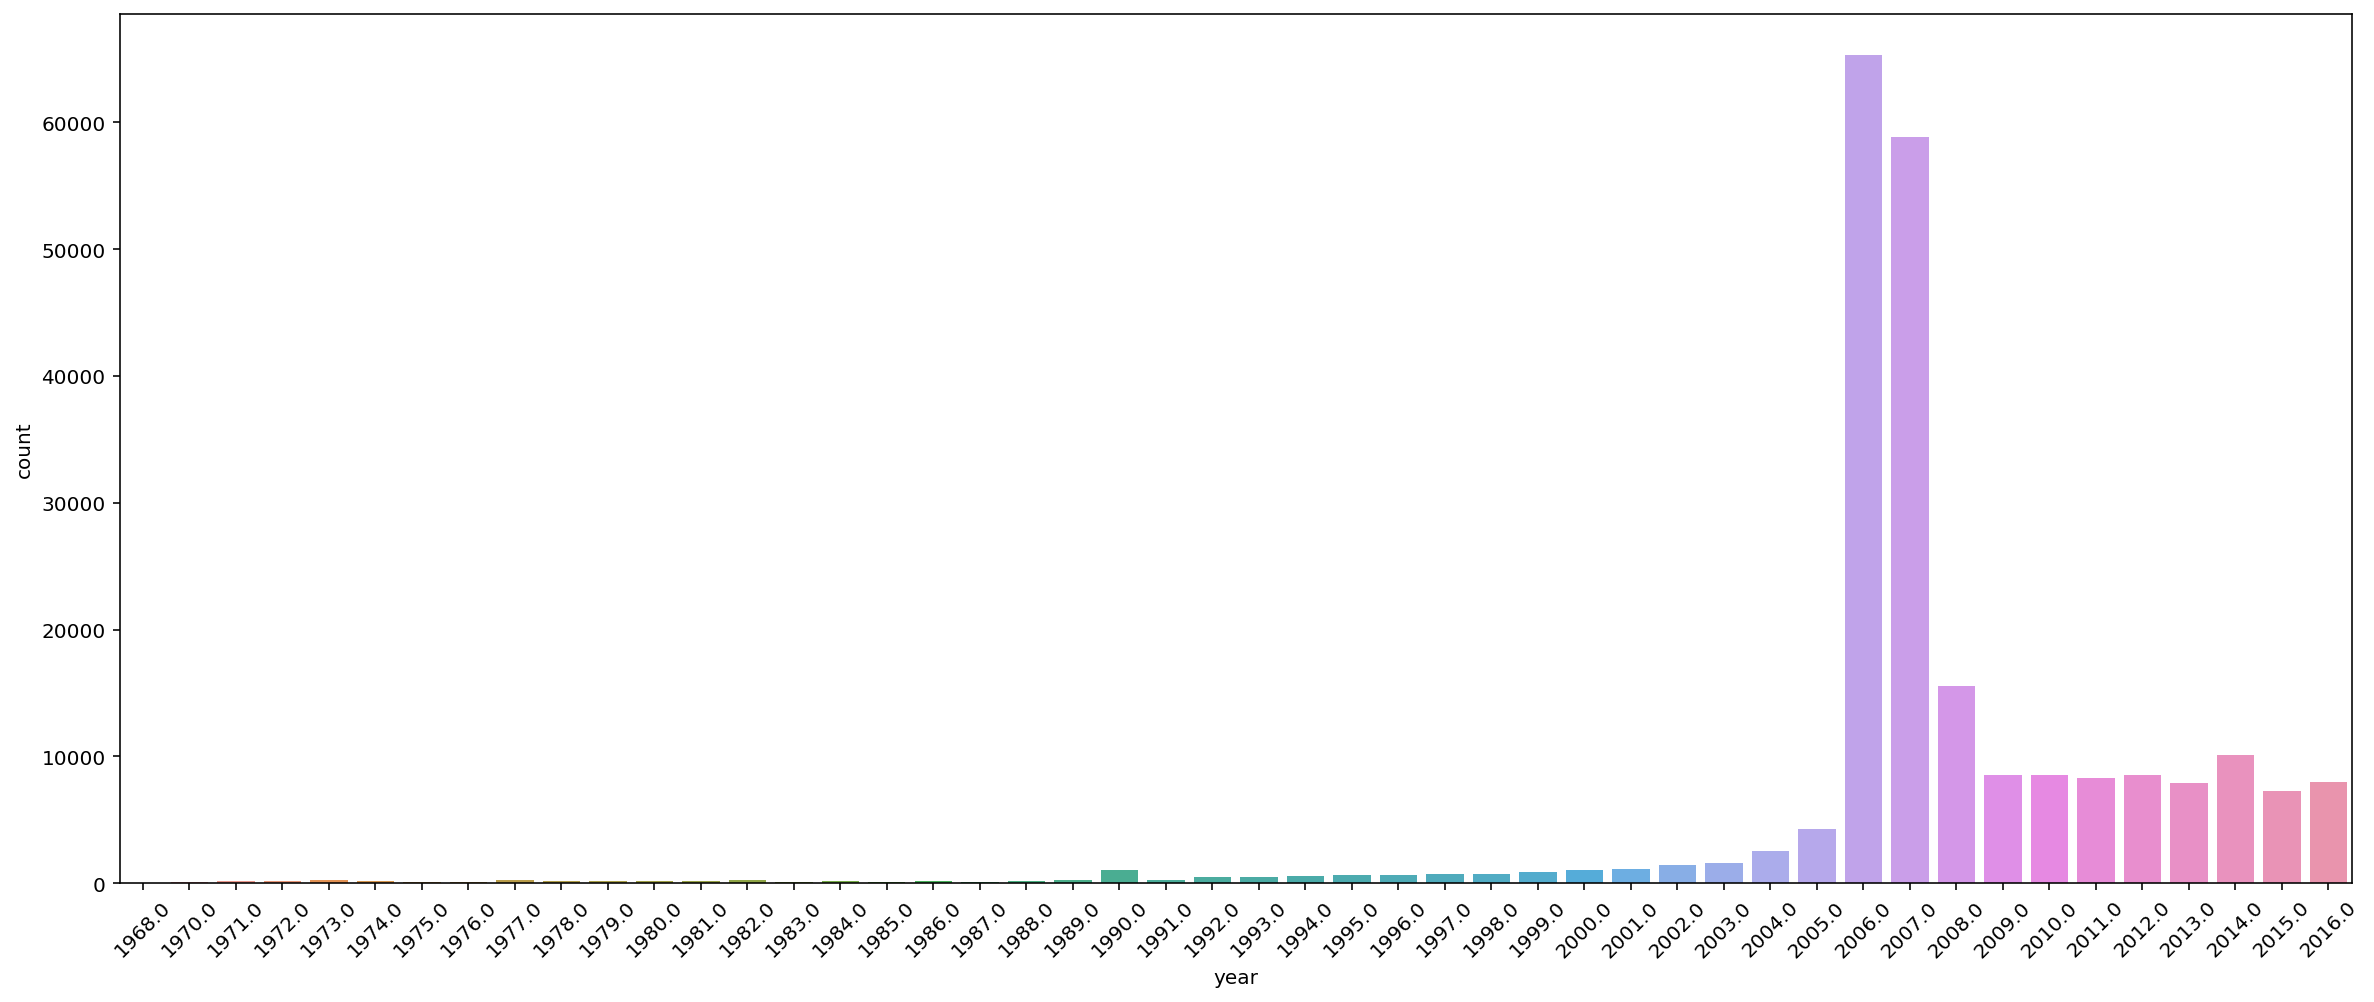

In [16]:
# visualising distribution of songs over time
# data is unevenly distributed and mostly from 2006/2007

plt.figure(figsize=(20,8))
ax = sns.countplot(df.year)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

I would have preferred for my data to be more evenly distributed across time as it would have been interesting to see if there were any evolutions in language from within each genre and if this would have helped to identify song genres.


In [17]:
print('Distribution of Genre in 2006:')
df[df.year == 2006].groupby('genre')['genre'].count().sort_values(ascending=False)


Distribution of Genre in 2006:


genre
Rock          36407
Pop           11723
Hip-Hop        6062
Metal          5922
Country        2154
Electronic     1880
Jazz           1164
Name: genre, dtype: int64

In [18]:
print('Distribution of Genre in 2007:')
df[df.year == 2007].groupby('genre')['genre'].count().sort_values(ascending=False)


Distribution of Genre in 2007:


genre
Rock          28551
Metal         12041
Country        6400
Pop            5684
Hip-Hop        3808
Jazz           1233
Electronic     1098
Name: genre, dtype: int64

In [19]:
df.genre.value_counts()


Rock          109235
Pop            40466
Hip-Hop        24850
Metal          23759
Country        14387
Jazz            7970
Electronic      7966
Name: genre, dtype: int64

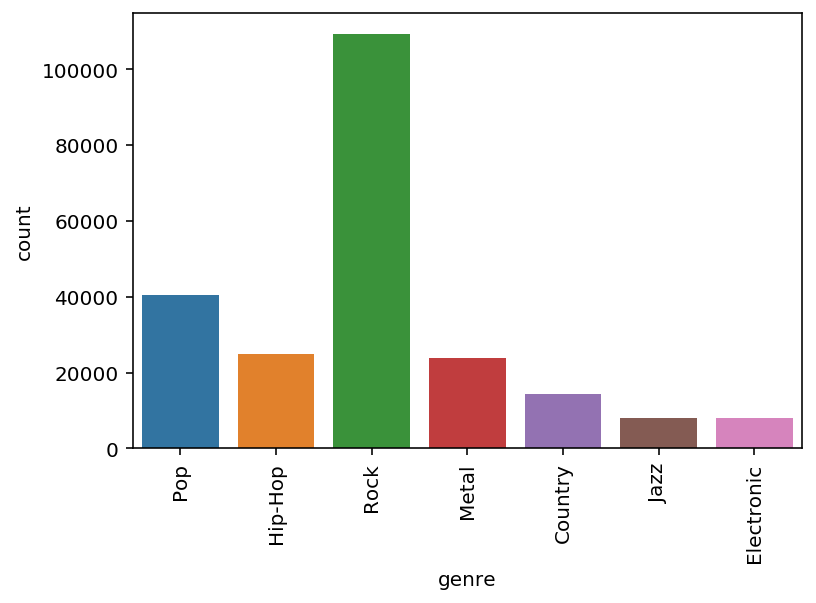

In [20]:
# rock will be reduced to 40,000 to even out distribution
# this is also to reduce the dataset to a size my laptop can manage better

sns.countplot(data=df, x='genre')
plt.xticks(rotation=90)
plt.show()

In [21]:
# removing 40,000 songs with the genre 'rock'

# I created a subset of my dataframe with on rock songs
df[df.genre == 'Rock'].shape[0] # 109235, same as count above

# Then I minused 40,000 from this, now I know I need to remove 69235 rows
num_to_remove = df[df.genre == 'Rock'].shape[0] - 40000

# Here I create a subset of the first 69235 from within the rock subset
remove = df[df.genre == 'Rock'][:num_to_remove]

# I think put the index numbers of the 'remove' subset into a list
remove_index = remove.index.to_list()

In [22]:
# if an index from the remove dataframe matches an index my original dataframe
# that row is removed from my original dataframe

for i in range(0, df.shape[0]):
    if i in remove_index:
        df.drop(i, inplace=True)
                    
df.reset_index(drop=True, inplace=True)  

In [23]:
df.shape # 159400

(159400, 5)

In [24]:
df.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-reduced-160120.csv', index=False)


In [2]:
df = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-reduced-160120.csv')

In [3]:
# checking new distribution in genre
df.genre.value_counts(normalize=True)

Pop           0.253868
Rock          0.250944
Hip-Hop       0.155899
Metal         0.149055
Country       0.090258
Jazz          0.050001
Electronic    0.049976
Name: genre, dtype: float64

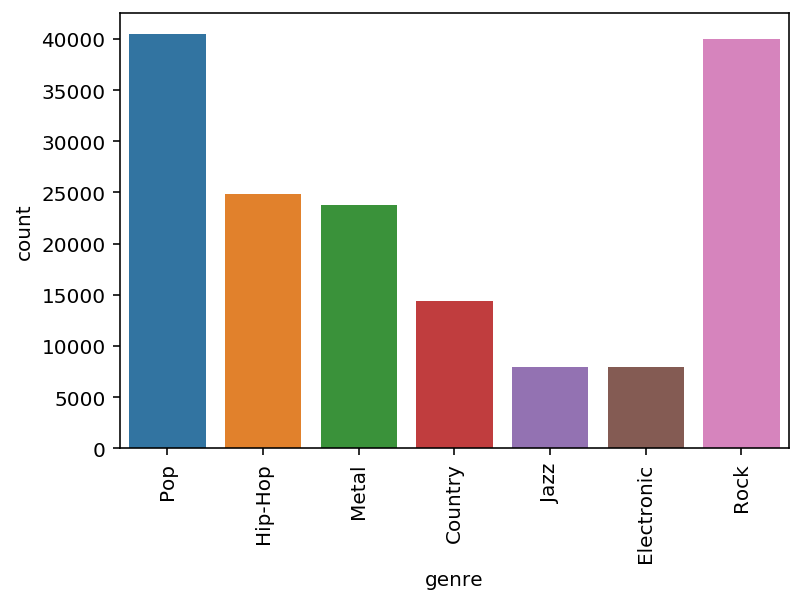

In [4]:
sns.countplot(data=df, x='genre')
plt.xticks(rotation=90)
plt.show()

### Collecting Audio Features Using Spotify's API

In [6]:
# if song cannot be found using search below, the nan dictionary will be appended so that everything 
# remains correctly formated / can easily be turned into a dataframe
    
nan_dict = {'danceability': np.nan,
                    'energy': np.nan,
                    'key': np.nan,
                    'loudness': np.nan,
                    'mode': np.nan,
                    'speechiness': np.nan,
                    'acousticness': np.nan,
                    'instrumentalness': np.nan,
                    'liveness': np.nan,
                    'valence': np.nan,
                    'tempo': np.nan,
                    'type': np.nan,
                    'id': np.nan,
                    'uri': np.nan,
                    'track_href': np.nan,
                    'analysis_url': np.nan,
                    'duration_ms': np.nan,
                    'time_signature': np.nan}

In [7]:
# token expires after approx 15,000 songs have been iterated over, hence why it is included in this function
# kaggle dataframe has been split into sections
# each time function is used on it, new token will be activated
   
def get_features(zipped):
    
    # getting token for spotify api, expires after 1 hour exactly
    client_id = 'c6ce241905234f6a9e1a12b0426a08ec'
    secret = '56f274ea215e4bf1be8c73d0f1e86a5f'
    url = 'http://localhost:8080'

    client_credentials_manager = SpotifyClientCredentials(client_id, secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    username = "Lyrics for Success"
    scope = 'user-library-read playlist-read-private'
    token = util.prompt_for_user_token(username, scope, client_id, secret, url)
    if token:
        sp = spotipy.Spotify(auth=token)
    else:
        print("Can't get token for", username)
    
    
    audio_features = []
    
    # pairing artists + tracks for search query
    for pair in tqdm_notebook(zipped):
        artist, track = pair
        
        # spotipy query framework
        results = sp.search(q='artist:{} track:{}'.format(artist, track), limit=1)
        
        # if no results are found append dictionary full of nan values so that rows remain aligned
        # with original dataframe
        if results['tracks']['items'] == []:
            audio_features.append(nan_dict)
        
        # otherwise append resulting audio features for song to list
        else:
            temp_id = results['tracks']['items'][0]['id']
            audio_features.append((sp.audio_features(temp_id)[0]))
        
    return audio_features

In [8]:
# extra cleaning for specific cases, searches did not work with if ' in song
df.song = df.song.str.replace("'", "").copy()
df.artist = df.artist.str.replace("beyonce knowles", "beyoncé").copy()

In [10]:
artist_names = df.artist[:10000] 
track_names = df.song[:10000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)

# issue where the api occasionally appends NoneType to list and breaks code, this function deals with that
# so it can be saved as a csv easily
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_1 = pd.DataFrame(audio_features)
kaggle_audio_1.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-1.csv', index=False)


CPU times: user 6min 36s, sys: 28.7 s, total: 7min 5s
Wall time: 41min 50s


In [12]:
artist_names = df.artist[10000:20000] 
track_names = df.song[10000:20000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_2 = pd.DataFrame(audio_features)
kaggle_audio_2.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-2.csv', index=False)


CPU times: user 6min 46s, sys: 29.4 s, total: 7min 16s
Wall time: 43min 4s


In [15]:
artist_names = df.artist[20000:30000] 
track_names = df.song[20000:30000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_3 = pd.DataFrame(audio_features)
kaggle_audio_3.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-3.csv', index=False)


CPU times: user 7min 22s, sys: 30.5 s, total: 7min 53s
Wall time: 41min 59s


In [17]:
artist_names = df.artist[30000:40000] 
track_names = df.song[30000:40000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_4 = pd.DataFrame(audio_features)
kaggle_audio_4.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-4.csv', index=False)


CPU times: user 6min 48s, sys: 28.9 s, total: 7min 17s
Wall time: 44min 30s


In [20]:
artist_names = df.artist[40000:50000] 
track_names = df.song[40000:50000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_5 = pd.DataFrame(audio_features)
kaggle_audio_5.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-5.csv', index=False)


CPU times: user 7min 12s, sys: 29.3 s, total: 7min 41s
Wall time: 43min 36s


In [21]:
artist_names = df.artist[50000:60000] 
track_names = df.song[50000:60000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_6 = pd.DataFrame(audio_features)
kaggle_audio_6.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-6.csv', index=False)


retrying ...1secs
CPU times: user 7min 37s, sys: 32.1 s, total: 8min 9s
Wall time: 43min 10s


In [23]:
artist_names = df.artist[60000:70000] 
track_names = df.song[60000:70000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_7 = pd.DataFrame(audio_features)
kaggle_audio_7.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-7.csv', index=False)


CPU times: user 7min 13s, sys: 31.2 s, total: 7min 45s
Wall time: 43min 4s


In [25]:
artist_names = df.artist[70000:80000] 
track_names = df.song[70000:80000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_8 = pd.DataFrame(audio_features)
kaggle_audio_8.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-8.csv', index=False)


CPU times: user 6min 59s, sys: 29.6 s, total: 7min 29s
Wall time: 44min 24s


In [27]:
artist_names = df.artist[80000:90000] 
track_names = df.song[80000:90000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_9 = pd.DataFrame(audio_features)
kaggle_audio_9.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-9.csv', index=False)


CPU times: user 7min 33s, sys: 34.6 s, total: 8min 7s
Wall time: 51min 53s


In [28]:
artist_names = df.artist[90000:100000] 
track_names = df.song[90000:100000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_10 = pd.DataFrame(audio_features)
kaggle_audio_10.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-10.csv', index=False)


CPU times: user 7min 47s, sys: 34.8 s, total: 8min 22s
Wall time: 44min 35s


In [30]:
artist_names = df.artist[100000:110000] 
track_names = df.song[100000:110000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_11 = pd.DataFrame(audio_features)
kaggle_audio_11.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-11.csv', index=False)


CPU times: user 7min 35s, sys: 30 s, total: 8min 5s
Wall time: 43min 8s


In [34]:
artist_names = df.artist[110000:120000] 
track_names = df.song[110000:120000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_12 = pd.DataFrame(audio_features)
kaggle_audio_12.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-12.csv', index=False)


retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
CPU times: user 6min 41s, sys: 29.4 s, total: 7min 11s
Wall time: 42min 7s


In [36]:
artist_names = df.artist[120000:130000] 
track_names = df.song[120000:130000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_13 = pd.DataFrame(audio_features)
kaggle_audio_13.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-13.csv', index=False)


CPU times: user 7min 18s, sys: 33.2 s, total: 7min 51s
Wall time: 43min 31s


In [40]:
artist_names = df.artist[140000:150000] 
track_names = df.song[140000:150000]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_14 = pd.DataFrame(audio_features)
kaggle_audio_14.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-14.csv', index=False)


CPU times: user 7min 42s, sys: 31.8 s, total: 8min 14s
Wall time: 42min 13s


In [42]:
artist_names = df.artist[150000:159400] 
track_names = df.song[150000:159400]

zipped = zip(artist_names, track_names)

%time audio_features = get_features(zipped)
        
audio_features = [nan_dict if x is None else x for x in audio_features]

kaggle_audio_15 = pd.DataFrame(audio_features)
kaggle_audio_15.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-15.csv', index=False)


CPU times: user 7min 5s, sys: 29.3 s, total: 7min 35s
Wall time: 39min 37s


In [43]:
# putting csvs with audio features into dataframes and joining them together
# should have same number of rows as original dataframe

kaggle_audio_1 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-1.csv')
kaggle_audio_2 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-2.csv')
kaggle_audio_3 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-3.csv')
kaggle_audio_4 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-4.csv')
kaggle_audio_5 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-5.csv')
kaggle_audio_6 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-6.csv')
kaggle_audio_7 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-7.csv')
kaggle_audio_8 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-8.csv')
kaggle_audio_9 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-9.csv')
kaggle_audio_10 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-10.csv')
kaggle_audio_11 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-11.csv')
kaggle_audio_12 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-12.csv')
kaggle_audio_13 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-13.csv')
kaggle_audio_14 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-14.csv')
kaggle_audio_15 = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/audio-features-15.csv')

audio_features_full = pd.concat([kaggle_audio_1, kaggle_audio_2, kaggle_audio_3, kaggle_audio_4, kaggle_audio_5,
                                kaggle_audio_6, kaggle_audio_7, kaggle_audio_8, kaggle_audio_9, kaggle_audio_10,
                                kaggle_audio_11, kaggle_audio_12, kaggle_audio_13, kaggle_audio_14, kaggle_audio_15], axis=0)

In [44]:
# reseting index
audio_features_full.reset_index(inplace=True, drop=True)

In [45]:
# final audio features dataframe
audio_features_full.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.114,https://api.spotify.com/v1/audio-analysis/7M4F...,0.711,283520.0,0.439,7M4F4e8lI8Dkod0IEtBx7x,0.0,1.0,0.0573,-5.156,1.0,0.1380,78.074,4.0,https://api.spotify.com/v1/tracks/7M4F4e8lI8Dk...,audio_features,spotify:track:7M4F4e8lI8Dkod0IEtBx7x,0.3260
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.428,https://api.spotify.com/v1/audio-analysis/1gTT...,0.565,224387.0,0.442,1gTT2Y987ndPot2Oygq6hn,0.0,2.0,0.1090,-7.738,1.0,0.0309,135.990,4.0,https://api.spotify.com/v1/tracks/1gTT2Y987ndP...,audio_features,spotify:track:1gTT2Y987ndPot2Oygq6hn,0.0717
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# original audio features
df.head()

,song,year,artist,genre,lyrics
0,ego remix,2009.0,beyoncé,Pop,Oh baby how you doing You know Im gonna cut ri...
1,then tell me,2009.0,beyoncé,Pop,playin everything so easy its like you seem so...
2,honesty,2009.0,beyoncé,Pop,If you search For tenderness It isnt hard to f...
3,you are my rock,2009.0,beyoncé,Pop,Oh oh oh I oh oh oh I If I wrote a book abou...
4,black culture,2009.0,beyoncé,Pop,Party the people the people the party its popp...


In [48]:
# audio features + kaggle dataframe joined together
final_df = pd.concat([df, audio_features_full], axis=1)
final_df.reset_index(inplace=True, drop=True)

In [50]:
# the audio features of 66,134 songs were not found and so will be dropped
final_df.isna().sum()

song                    1
year                    2
artist                  1
genre                   2
lyrics                  3
acousticness        66134
analysis_url        66134
danceability        66134
duration_ms         66134
energy              66134
id                  66134
instrumentalness    66134
key                 66134
liveness            66134
loudness            66134
mode                66134
speechiness         66134
tempo               66134
time_signature      66134
track_href          66134
type                66134
uri                 66134
valence             66134
dtype: int64

In [52]:
final_df.dropna(inplace=True)

In [53]:
final_df.shape # 93265 rows remain

(93265, 23)

In [54]:
final_df.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-final-190120.csv', index=False)